<a href="https://colab.research.google.com/github/kotech1/computervision/blob/master/12_deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습 파일: `12-deepfake.ipynb`

# Errata

1. 정규분포와 표준정규분포 간의 KL divergence 식  
   강의 노트에는 다음과 같이 표시되어 있었습니다.  
   $$
   D_{KL}(p\parallel q) = {1\over2}\left(\sigma^2 + \mu^2 -\log\sigma -1\right)
   $$
   이것을 다음과 같이 정정합니다.  
   $$
   D_{KL}(p\parallel q) = {1\over2}\left(\sigma^2 + \mu^2 -\log\sigma^2 -1\right)
   $$
   계산 과정:  
   $$
   \begin{align*}
   -\langle\log q\rangle &= {1\over2}\langle x^2\rangle - \log{1\over\sqrt{2\pi}}\\
   &= {1\over2}\left(\sigma^2+\mu^2\right) + \log\sqrt{2\pi}\\
   \langle\log p\rangle &= -{1\over2}-\log\sqrt{2\pi}\sigma\\
   &= -{1\over2}-\log\sqrt{2\pi} - \log\sigma \\
   D_{KL}(p\parallel q) &= -\langle\log q\rangle+\langle\log p\rangle\\
   &={1\over2}\left(\sigma^2 + \mu^2-1-2\log\sigma\right)\\
   &= {1\over2}\left(\sigma^2 + \mu^2 -\log\sigma^2 -1\right)
   \end{align*}
   $$

2. 3차시 실습 동영상 20:50초경  
   실습 동영상에서 안경을 씌우는 코드 설명 부분에 원본 이미지의 z 벡터에서 생성한 얼굴이 맨 왼쪽이라고 설명하였는데, 이것은 잘못된 설명입니다.  
   안경을 씌우는 9개의 이미지 중 맨 가운데 이미지가 원본 이미지의 z 값으로부터 생성된 이미지 입니다.    
   `add_vector_to_images()` 함수에서 `factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]`를 변경하면서 attribute vector에 곱해서 원본 z에 더해주도록 되어 있습니다.  

# Variational autoencoder

In [1]:
#!pip install --upgrade gdown

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


**CelebA dataset**  
공식 구글 드라이브가 사용용량으로 다운로드가 불가능한 경우가 있습니다.  
미러 링크 등을 이용하시면 됩니다.  


In [3]:
import gdown
md5 = '00d2c5bc6d35e252742224ab0c1e8fcb'
# official download link
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM'
# mirror url
url = 'https://drive.google.com/uc?id=1vsObPMdbOQwysIb-XulliKXqRSKrw6Iq'
output = '/mydrive/img_align_celeba.zip'
gdown.cached_download(url, output, md5=md5)


Computing MD5: /mydrive/img_align_celeba.zip
MD5 matches: /mydrive/img_align_celeba.zip


'/mydrive/img_align_celeba.zip'

CelebA attribute data

In [4]:
import gdown
md5 = '4414d5bdd90f37e4a8548c501e098835'
# official download link
url = 'https://drive.google.com/uc?id=1epcRzi5e2IzuWhAMNaigYtyRhwUq72-2'
output = '/mydrive/list_attr_celeba.csv'
gdown.cached_download(url, output, md5=md5)

Computing MD5: /mydrive/list_attr_celeba.csv
MD5 matches: /mydrive/list_attr_celeba.csv


'/mydrive/list_attr_celeba.csv'

In [5]:
!mkdir -p vae_data/celeb
!mkdir -p vae_data/weights

In [6]:
!unzip -o /mydrive/img_align_celeba.zip -d vae_data/celeb

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: vae_data/celeb/img_align_celeba/197600.jpg  
 extracting: vae_data/celeb/img_align_celeba/197601.jpg  
 extracting: vae_data/celeb/img_align_celeba/197602.jpg  
 extracting: vae_data/celeb/img_align_celeba/197603.jpg  
 extracting: vae_data/celeb/img_align_celeba/197604.jpg  
 extracting: vae_data/celeb/img_align_celeba/197605.jpg  
 extracting: vae_data/celeb/img_align_celeba/197606.jpg  
 extracting: vae_data/celeb/img_align_celeba/197607.jpg  
 extracting: vae_data/celeb/img_align_celeba/197608.jpg  
 extracting: vae_data/celeb/img_align_celeba/197609.jpg  
 extracting: vae_data/celeb/img_align_celeba/197610.jpg  
 extracting: vae_data/celeb/img_align_celeba/197611.jpg  
 extracting: vae_data/celeb/img_align_celeba/197612.jpg  
 extracting: vae_data/celeb/img_align_celeba/197613.jpg  
 extracting: vae_data/celeb/img_align_celeba/197614.jpg  
 extracting: vae_data/celeb/img_align_celeba/197615.jpg  
 extracting: vae_data/celeb/img_alig

In [7]:
!cp /mydrive/list_attr_celeba.csv vae_data/celeb

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import os
from glob import glob

In [9]:
SAVE_FOLDER = 'vae_data'
DATA_FOLDER = SAVE_FOLDER + '/celeb/'

INPUT_DIM = (128,128,3)
BATCH_SIZE = 32

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))

NUM_IMAGES = len(filenames)

mode =  'build' #'load' #
#mode =  'load'

**학습용 Data Generator**

In [10]:
data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = BATCH_SIZE
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )

Found 202599 images belonging to 1 classes.


**Sampling 레이어**  
standard normal distritubion인 $\epsilon$ 샘플링으로부터   
$\mu$와 $\sigma$의 정규분포를 생성하는 레이어  
$ N(\mu, \sigma) = \mu + \sigma N(0, 1) = \mu + \sigma\epsilon$  

In [11]:
class Sampling(layers.Layer):
    """Uses (mu, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(log_var/2) * epsilon

**Encoder 모델 정의**  
Latent space의 차원: 200

In [12]:
z_dim = 200
r_loss_factor = 10000

encoder_input = keras.Input(shape=INPUT_DIM, name='encoder_input')
x = Conv2D(32, 3, strides=2, padding="same", name='encoder_conv_0')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
mu = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)
z = Sampling(name='encoder_output')([mu, log_var])
encoder = keras.Model(encoder_input, [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 32)           128       ['encoder_conv_0[0][0]']      
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)           0         ['batch_normalization[0]

**Decoder 모델 정의**


In [13]:
decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t0')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(3, 3, strides=2, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 4096)              823296    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 decoder_conv_t0 (Conv2DTra  (None, 16, 16, 64)        36928     
 nspose)                                                         
                                                                 
 batch_normalization_4 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0   

**Variational Autoencoder 모델 정의**  
`keras.Model` 클래스를 상속받아서 새로 정의함  

$D_{KL}(p\parallel q)={1\over 2}\left(\sigma^2+\mu^2-2\log\sigma-1 \right )$  

In [14]:

class VAEModel(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        #self.r_loss_factor = r_loss_factor

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                #tf.square(data - reconstruction)
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= r_loss_factor
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": tf.reduce_mean(total_loss),
            "reconstruction_loss": tf.reduce_mean(reconstruction_loss),
            "kl_loss": tf.reduce_mean(kl_loss),
        }

    def call(self,inputs):
        _,_,latent = self.encoder(inputs)
        return self.decoder(latent)

In [15]:
LEARNING_RATE = 0.0005
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

save_folder = os.path.join(SAVE_FOLDER, 'weights')

VAE = VAEModel(encoder, decoder)
VAE.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [16]:
MODE = 'build'
#MODE = 'load'

if MODE == 'load':
    #ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    VAE.load_weights(save_folder+'/'+'checkpoint')

**Train**

In [17]:
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr

    return LearningRateScheduler(schedule)

checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint', save_weights_only = True, verbose=1)
lr_sched = step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=1, step_size=1)
callbacks_list = [checkpoint, lr_sched]

VAE.fit(
    data_flow,
    shuffle=True,
    epochs=EPOCHS,
    steps_per_epoch = NUM_IMAGES / BATCH_SIZE,
    callbacks=callbacks_list
)

Epoch 1/200
6332/6331 [==============================] - ETA: 0s - loss: 5206.3612 - reconstruction_loss: 5090.8805 - kl_loss: 115.4807
Epoch 1: saving model to vae_data/weights/checkpoint
6331/6331 [==============================] - 341s 52ms/step - loss: 5206.3279 - reconstruction_loss: 5090.8464 - kl_loss: 115.4814 - lr: 5.0000e-04
Epoch 2/200
3549/6331 [===============>..............] - ETA: 2:06 - loss: 5121.2971 - reconstruction_loss: 5001.4088 - kl_loss: 119.8883

KeyboardInterrupt: ignored

In [22]:
!ls vae_data/weights

checkpoint  checkpoint.data-00000-of-00001  checkpoint.index


학습이 완료된 모델 weights 저장

In [20]:
VAE.save_weights(save_folder+'/checkpoint')

In [25]:
!rm -r /mydrive/vae
!mkdir -p /mydrive/vae
!cp -r vae_data/weights /mydrive/vae

미리 학습된 weights 다운로드

In [26]:
#md5 = 'b387a8f59bd8bc09ee1eb12a80294379'
#url = 'https://drive.google.com/uc?id=19m6cQVNqXRhD6iEGkjA8ZZcOdev_b2V1'
#output = 'vae_weights.tar.gz'

md5 = 'c26f1be89f836f799fd3005934f327a7'
url = 'https://drive.google.com/uc?id=1p55tpOsVcliNMLCbQF5ogqZ6tfQH_-nK'
output = 'vae_weights.tar.gz'

gdown.cached_download(url, output, md5=md5)

Cached Downloading: vae_weights.tar.gz
Downloading...
From: https://drive.google.com/uc?id=1p55tpOsVcliNMLCbQF5ogqZ6tfQH_-nK
To: /root/.cache/gdown/tmper7e_r1k/dl
100%|██████████| 29.5M/29.5M [00:00<00:00, 45.6MB/s]

Computing MD5: vae_weights.tar.gz
MD5 matches: vae_weights.tar.gz


'vae_weights.tar.gz'

weights 압축 해제

In [10]:
!tar xvzf vae_weights.tar.gz -C vae_data

tar (child): vae_weights.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


weights 로드

In [28]:
VAE.load_weights(save_folder+'/'+'checkpoint')

## VAE 분석

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

vae = VAE


In [30]:
DATA_FOLDER = './vae_data/celeb/'
IMAGE_FOLDER = './vae_data/celeb/img_align_celeba/'

In [31]:
class ImageLabelLoader():
    def __init__(self, image_folder, target_size):
        self.image_folder = image_folder
        self.target_size = target_size

    def build(self, att, batch_size, label = None):

        data_gen = ImageDataGenerator(rescale=1./255)
        if label:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , y_col=label
                , target_size=self.target_size
                , class_mode='raw'
                , batch_size=batch_size
                , shuffle=True
            )
        else:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , target_size=self.target_size
                , class_mode='input'
                , batch_size=batch_size
                , shuffle=True
            )

        return data_flow

In [32]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

In [33]:
att.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

**이미지 복원**

Found 202599 validated image filenames.
1/1 [==============================] - 0s 290ms/step


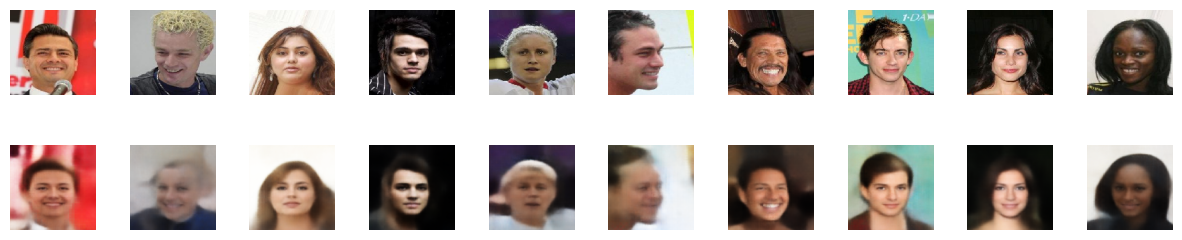

In [34]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

_,_,z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

**새로 얼굴 생성하기**

1/1 [==============================] - 0s 253ms/step


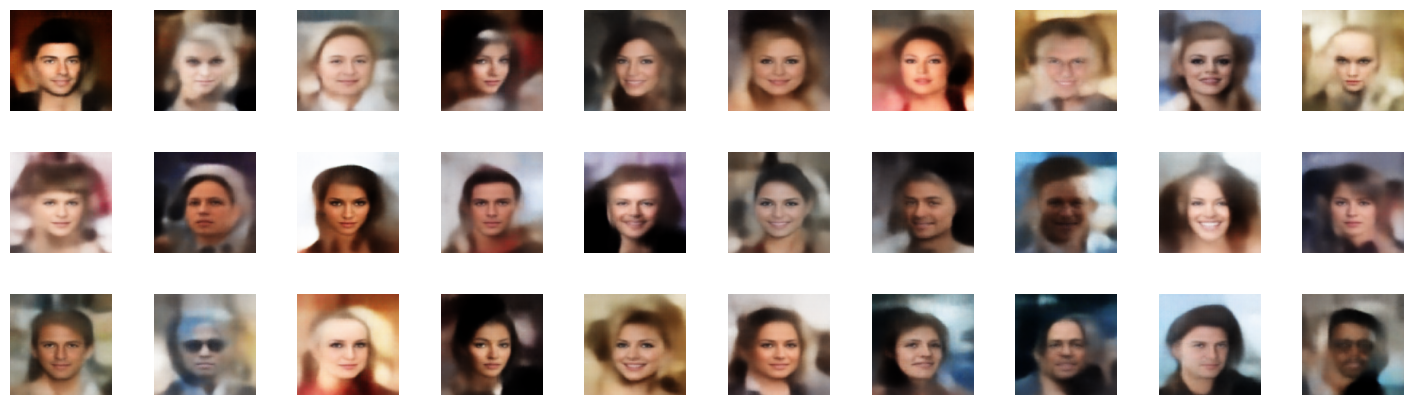

In [35]:
z_dim = 200
n_to_show = 30

znew = np.random.normal(size = (n_to_show,z_dim))/1

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [36]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        _,_,z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector

In [37]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    _,_,z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()

In [38]:
BATCH_SIZE = 500
# attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
# mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
# smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
# lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
# young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
# male_vec = get_vector_from_label('Male', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
# blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
16/16 [==============================] - 0s 13ms/step
32    : 3.298    : 0.763    : 3.456    : 3.456
16/16 [==============================] - 0s 5ms/step
64    : 1.837    : 0.501    : 2.932    : -0.524
16/16 [==============================] - 0s 5ms/step
99    : 1.095    : 0.25    : 2.47    : -0.462
16/16 [==============================] - 0s 5ms/step
132    : 0.672    : 0.187    : 2.497    : 0.027
16/16 [==============================] - 0s 5ms/step
166    : 0.59    : 0.142    : 2.325    : -0.172
16/16 [==============================] - 0s 5ms/step
203    : 0.506    : 0.114    : 2.348    : 0.023
16/16 [==============================] - 0s 5ms/step
232    : 0.386    : 0.104    : 2.388    : 0.04
16/16 [==============================] - 0s 5ms/step
252    : 0.255    : 0.089    : 2.369    : -0.019
16/16 [==============================] - 0s 5ms/step
295    : 0.36    : 0.074    : 2

다음 cell을 수행하시면 원본 이미지의 z값에서 각 attribute vector를 가감한 결과가 출력됩니다.
Attribute vector에 factor를 곱할때 가중치를 `[-4,-3,-2,-1,0,1,2,3,4]`로 변화시키면서 출력하기 때문에, 가운데 이미지가 원본 이미지로부터 생성된 z 값으로 생성된 것이고, 왼쪽으로 갈수록 attribute vector를 감소시킨 결과, 오른쪽으로 갈수록 attribute vector를 더한 결과입니다.  

Eyeglasses Vector
1/1 [==============================] - 0s 18ms/step


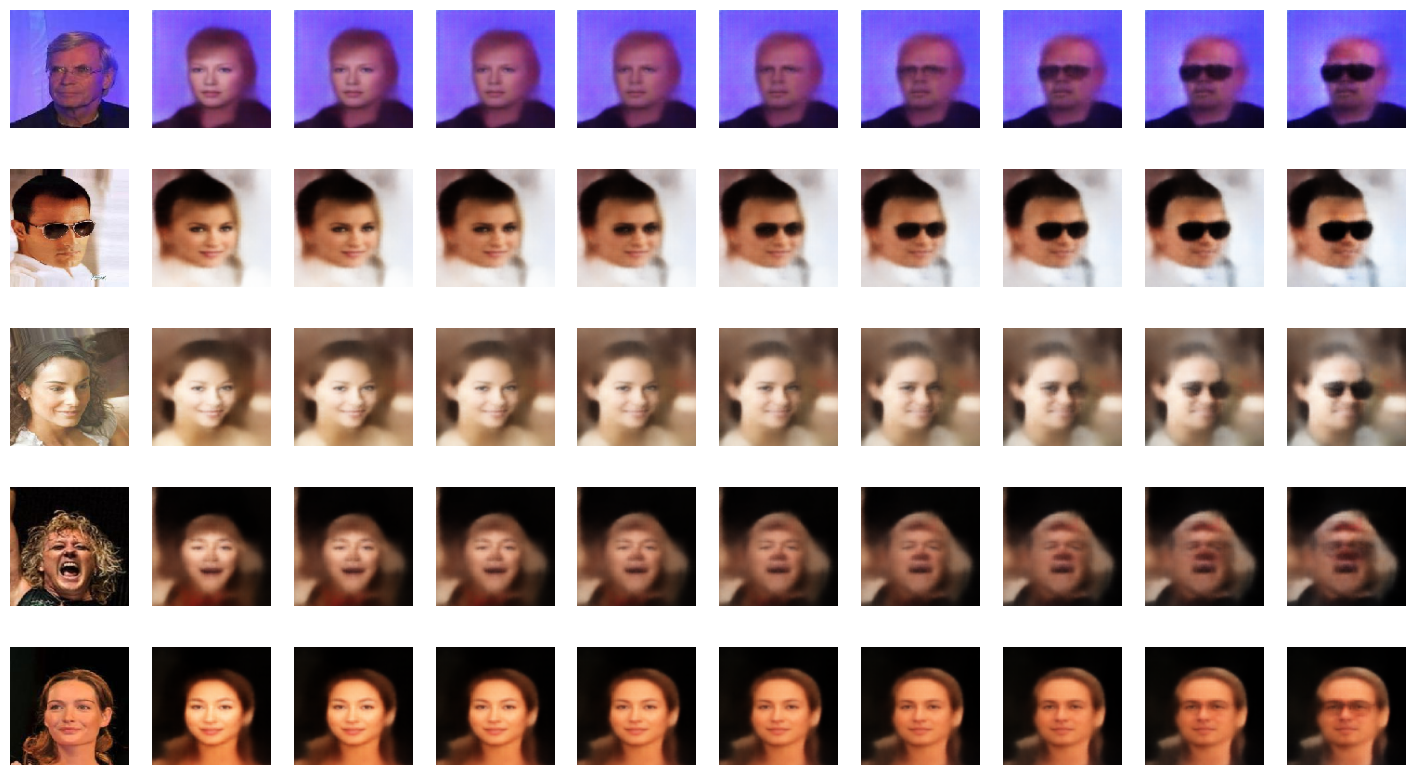

In [39]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

In [40]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    _,_,z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')
    sub.imshow(img)


    plt.show()

Found 2 validated image filenames.
1/1 [==============================] - 0s 16ms/step


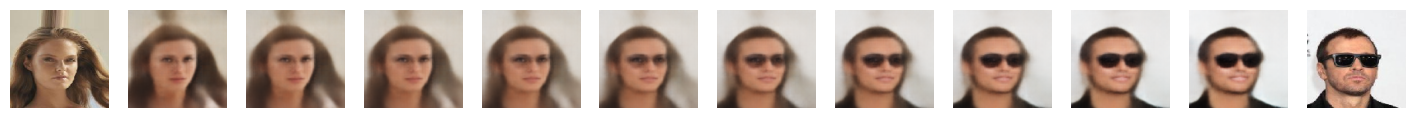

In [41]:
start_image_file = '000238.jpg'
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.
1/1 [==============================] - 0s 26ms/step


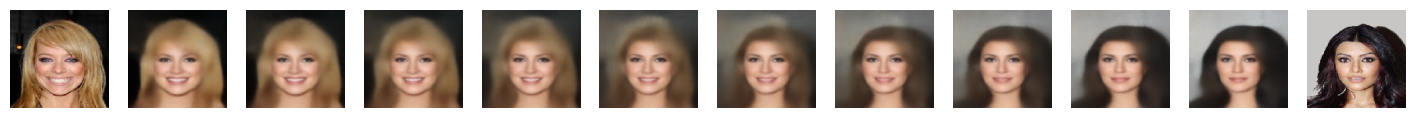

In [42]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.
1/1 [==============================] - 0s 27ms/step


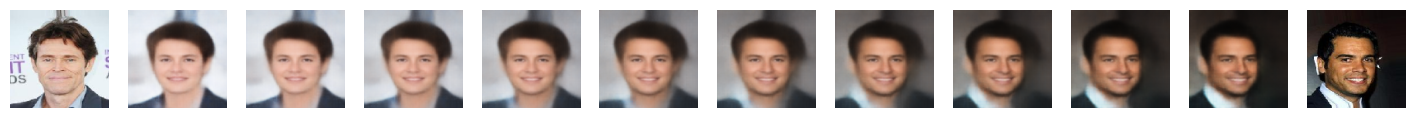

In [43]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)

# Face swapping

Original source code from:  
https://github.com/EXJUSTICE/DeepFake_FaceSwap  

In [1]:
%cd /content
!git clone -b tensorflow2.update --single-branch https://github.com/shevious/DeepFake_FaceSwap.git --depth=1

/content
Cloning into 'DeepFake_FaceSwap'...
remote: Enumerating objects: 450, done.
remote: Counting objects: 100% (450/450), done.
remote: Compressing objects: 100% (447/447), done.
remote: Total 450 (delta 5), reused 442 (delta 3), pack-reused 0
Receiving objects: 100% (450/450), 14.51 MiB | 30.83 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
%cd /content/DeepFake_FaceSwap

/content/DeepFake_FaceSwap


In [11]:
!mkdir -p obama-cut
!mkdir -p clinton-cut
!mkdir -p saved_model
!mkdir -p test

In [3]:
!pip list | grep scipy

scipy                            1.10.1


In [12]:
!pip install Pillow

In [7]:
!pip install scipy

In [8]:
import scipy.misc

In [10]:
import imageio

In [12]:
scipy.misc.imread = imageio.imread

In [12]:
!pip install face_recognition
!pip install scandir

In [13]:
import cv2
from pathlib import Path
import face_recognition
from lib_1.PluginLoader import PluginLoader
from lib_1.faces_detect import detect_faces
from lib_1.FaceFilter import FaceFilter
import os

In [14]:
input_directory="obama-jpg"
output_directory="obama-cut"
filter_file = 'filter/obamafilter.jpg'

In [15]:
def load_filter():
    #filter_file = '../content/filter/obamafilter.jpg' # TODO Change argument here depending on what youre trying to extract
    if os.path.exists(filter_file):
        print('Loading reference image for filtering')
        return FaceFilter(filter_file)
    else:
        print("Filter not detected")

def get_faces(image):
    faces_count = 0
    filterDeepFake = load_filter()

    for face in detect_faces(image):

        if filterDeepFake is not None and not filterDeepFake.check(face):
            print('Skipping not recognized face!')
            continue


        yield faces_count, face

In [16]:
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

extractor_name = "Align" # TODO Pass as argument
extractor = PluginLoader.get_extractor(extractor_name)()

Loading Extract from Extract_Align plugin...


**얼굴 이미지 추출**

In [17]:
"""

#Single Example test

example  ="../content/data/CR_2012.jpg"


image = cv2.imread(example)

for idx, face in get_faces(image):
           resized_image = extractor.extract(image, face, 256)
           output_file = output_directory+"/"+str(Path(example).stem)
           cv2.imwrite(str(output_file) + str(idx) + Path(example).suffix, resized_image)
"""
#Simply iterating over the folder is insufficient, imread needs paths, so create them into a list.


def find_all_files(directory):
    for root, dirs, files in os.walk(directory):

        for file in files:
            p=os.path.join(root, file)
            p=p.split("/")[len(p.split("/"))-2]
            name, ext = os.path.splitext(p)

            yield os.path.join(root, file)

folder_img = find_all_files(input_directory)
try:
    for filename in folder_img:
        image = cv2.imread(filename)
        print(filename)
        for idx, face in get_faces(image):
            print('extractor')
            resized_image = extractor.extract(image, face, 256)
            output_file = output_directory+"/"+str(Path(filename).stem)
            print('imwrite')
            cv2.imwrite(str(output_file) + str(idx) + Path(filename).suffix, resized_image)

except Exception as e:
    print('Failed to extract from image: {}. Reason: {}'.format(filename, e))

input_directory="clinton-jpg"
output_directory="clinton-cut"
filter_file = 'filter/clintonfilter.jpg'

folder_img = find_all_files(input_directory)
try:
    for filename in folder_img:
        image = cv2.imread(filename)
        print(filename)
        for idx, face in get_faces(image):
            print('extractor')
            resized_image = extractor.extract(image, face, 256)
            output_file = output_directory+"/"+str(Path(filename).stem)
            print('imwrite')
            cv2.imwrite(str(output_file) + str(idx) + Path(filename).suffix, resized_image)

except Exception as e:
    print('Failed to extract from image: {}. Reason: {}'.format(filename, e))

obama-jpg/102.jpg
Loading reference image for filtering
-----
check
[0.28486406]
extractor
imwrite
obama-jpg/009.jpg
Loading reference image for filtering
-----
check
[0.26448136]
extractor
imwrite
obama-jpg/044.jpg
Loading reference image for filtering
-----
check
[0.34536438]
extractor
imwrite
obama-jpg/006.jpg
Loading reference image for filtering
-----
check
[0.34122643]
extractor
imwrite
check
No faces found in the image!
0.8
Skipping not recognized face!
obama-jpg/148.jpg
Loading reference image for filtering
-----
check
[0.31092529]
extractor
imwrite
obama-jpg/039.jpg
Loading reference image for filtering
-----
check
[0.40024183]
extractor
imwrite
obama-jpg/008.jpg
Loading reference image for filtering
-----
check
[0.31200389]
extractor
imwrite
obama-jpg/055.jpg
Loading reference image for filtering
-----
check
[0.34611889]
extractor
imwrite
obama-jpg/111.jpg
Loading reference image for filtering
-----
check
[0.28829992]
extractor
imwrite
obama-jpg/048.jpg
Loading reference imag

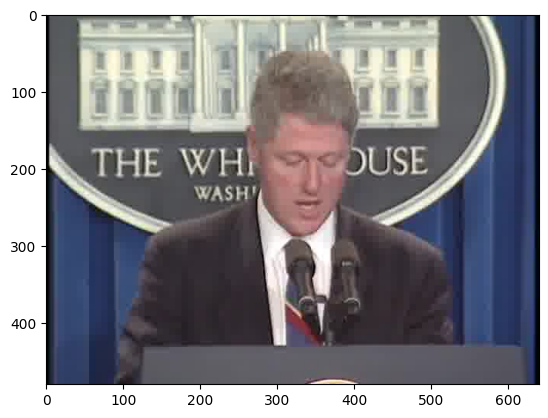

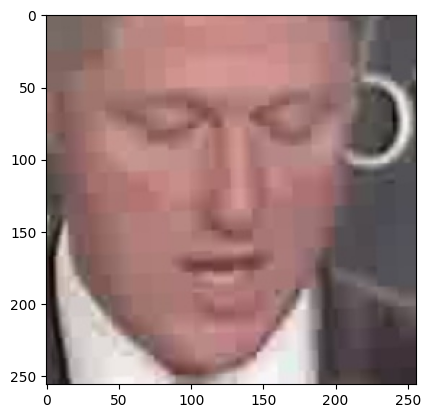

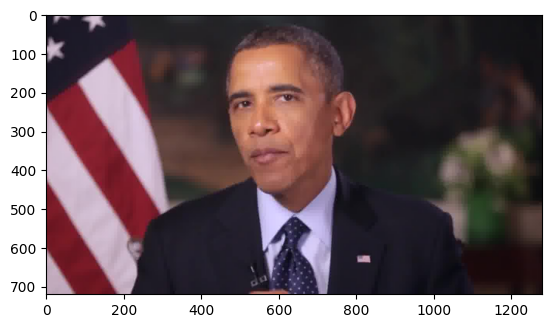

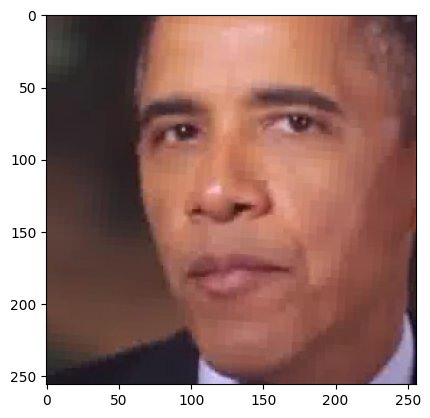

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

img = mp_image.imread('clinton-jpg/076.jpg')
plt.imshow(img)
plt.show()
img = mp_image.imread('clinton-cut/0760.jpg')
plt.imshow(img)
plt.show()
img = mp_image.imread('obama-jpg/076.jpg')
plt.imshow(img)
plt.show()
img = mp_image.imread('obama-cut/0760.jpg')
plt.imshow(img)
plt.show()

## 학습하기

In [19]:
import gdown
md5 = 'd1b5f39e88b70cd3661b73b36f296586'
# pretrained weights for speed up
url = 'https://drive.google.com/uc?id=1biKvZSxV-Dx9mUX-UMaFcZ6J8OMQ9MHQ'
output = 'weights2.zip'
gdown.cached_download(url, output, md5=md5)

Cached Downloading: weights2.zip
Downloading...
From: https://drive.google.com/uc?id=1biKvZSxV-Dx9mUX-UMaFcZ6J8OMQ9MHQ
To: /root/.cache/gdown/tmpbs_i1ymz/dl
100%|██████████| 304M/304M [00:04<00:00, 64.5MB/s]


Computing MD5: weights2.zip
MD5 matches: weights2.zip


'weights2.zip'

In [20]:
!unzip weights2.zip

Archive:  weights2.zip
   creating: weight/
  inflating: weight/decoder_A.h5     
  inflating: weight/decoder_B.h5     
  inflating: weight/encoder.h5       


In [21]:
import cv2
import numpy
import time

from pathlib import Path
from scandir import scandir

from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam

from lib_1.PixelShuffler import PixelShuffler
import time
import numpy
from lib_1.training_data import minibatchAB, stack_images

In [22]:

sav_Model="saved_model"
pretrained_weight="weight"
# 계속해서 train할 경우 아래의 저장 폴더를 이용
#pretrained_weight="saved_model"
image_actor_A_directory="obama-cut" #ORIGINAL
image_actor_B_directory="clinton-cut" #TARGET TO REPLACE WITH
batch_size=32
save_interval=500
ENCODER_DIM = 1024


#DON'T MODIFY
image_extensions = [".jpg", ".jpeg", ".png"]
encoderH5 = '/encoder.h5'
decoder_AH5 = '/decoder_A.h5'
decoder_BH5 = '/decoder_B.h5'
IMAGE_SHAPE = (64, 64, 3)

In [23]:
class dfModel():
    def __init__(self):
        self.model_dir = sav_Model
        self.pretrained_weight=pretrained_weight
        self.encoder = self.Encoder()
        self.decoder_A = self.Decoder()
        self.decoder_B = self.Decoder()

        self.initModel()

    def initModel(self):
        optimizer1 = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999) #orig adam 5e-5
        optimizer2 = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999) #orig adam 5e-5

        x = Input(shape=IMAGE_SHAPE)

        self.autoencoder_A = KerasModel(x, self.decoder_A(self.encoder(x)))
        self.autoencoder_B = KerasModel(x, self.decoder_B(self.encoder(x)))
        print(self.encoder.summary())
        print(self.decoder_A.summary())

        self.autoencoder_A.compile(optimizer=optimizer1, loss='mean_absolute_error')
        self.autoencoder_B.compile(optimizer=optimizer2, loss='mean_absolute_error')

    def converter(self, swap):
        autoencoder = self.autoencoder_B if not swap else self.autoencoder_A
        return lambda img: autoencoder.predict(img)

    def conv(self, filters):
        def block(x):
            x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            return x
        return block

    def upscale(self, filters):
        def block(x):
            x = Conv2D(filters * 4, kernel_size=3, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            x = PixelShuffler()(x)
            #Pixelshufflers job here is analoguous to upsampling2d
            return x
        return block

    #Note how no maxpooling after every layer here, we are generating a WARPED image, not a lower dimensional representation first.
    def Encoder(self):
        input_ = Input(shape=IMAGE_SHAPE)
        x = input_
        x = self.conv(128)(x)
        x = self.conv(256)(x)
        x = self.conv(512)(x)
        x = self.conv(1024)(x)
        x = Dense(ENCODER_DIM)(Flatten()(x))
        x = Dense(4 * 4 * 1024)(x)
        #Passed flattened X input into 2 dense layers, 1024 and 1024*4*4
        x = Reshape((4, 4, 1024))(x)
        #Reshapes X into 4,4,1024
        x = self.upscale(512)(x)
        return KerasModel(input_, x)

    def Decoder(self):
        input_ = Input(shape=(8, 8, 512))
        x = input_
        x = self.upscale(256)(x) #Actually 1024 given filters*4
        x = self.upscale(128)(x) #Actually 512
        x = self.upscale(64)(x) #Actually 256
        x = Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
        return KerasModel(input_, x)

    def load(self, swapped):
        (face_A,face_B) = (decoder_AH5, decoder_BH5) if not swapped else (decoder_BH5, decoder_AH5)
        try:
            self.encoder.load_weights(self.pretrained_weight + encoderH5)
            self.decoder_A.load_weights(self.pretrained_weight + face_A)
            self.decoder_B.load_weights(self.pretrained_weight + face_B)
            print('loaded model weights')
            return True
        except Exception as e:
            print('Failed loading existing training data.')
            print(e)
            return False

    def save_weights(self):
        self.encoder.save_weights(self.model_dir + encoderH5)
        self.decoder_A.save_weights(self.model_dir + decoder_AH5)
        self.decoder_B.save_weights(self.model_dir + decoder_BH5)
        print('saved model weights')


In [24]:
class Trainer():
    def __init__(self, model, fn_A, fn_B, batch_size=64):
        self.batch_size = batch_size
        self.model = model
        self.images_A = minibatchAB(fn_A, self.batch_size)
        self.images_B = minibatchAB(fn_B, self.batch_size)

    def train_one_step(self, iter):
        epoch, warped_A, target_A = next(self.images_A)
        epoch, warped_B, target_B = next(self.images_B)

        loss_A = self.model.autoencoder_A.train_on_batch(warped_A, target_A)
        loss_B = self.model.autoencoder_B.train_on_batch(warped_B, target_B)
        print("[{0}] [#{1:05d}] loss_A: {2:.5f}, loss_B: {3:.5f}".format(time.strftime("%H:%M:%S"), iter, loss_A, loss_B),
            end='\r')

In [25]:
def get_image_paths(directory):
    return [x.path for x in scandir(directory) if
     any(map(lambda ext: x.name.lower().endswith(ext), image_extensions))]

In [26]:
model = dfModel()
model.load(swapped=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         3277312   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 512)         0     

True

In [27]:
images_A = get_image_paths(image_actor_A_directory)
images_B = get_image_paths(image_actor_B_directory)
trainer = Trainer(model,images_A,images_B,batch_size=batch_size)

for epoch in range(0, 1000000):

    save_iteration = epoch % save_interval == 0

    trainer.train_one_step(epoch)

    if save_iteration:
        print('epoch =', epoch)
        model.save_weights()

epoch = 0
saved model weights


KeyboardInterrupt: ignored

## 생성하기

In [28]:
import gdown
md5 = 'b2b747e22727313ed5f64323a6e041ee'
# 학습하기
url = 'https://drive.google.com/uc?id=1DbGpF_nhVJMeRaVcSVZRh1I1xfp7_dAj'
output = 'saved_model_obama.tar.gz'
gdown.cached_download(url, output, md5=md5)

Cached Downloading: saved_model_obama.tar.gz
Downloading...
From: https://drive.google.com/uc?id=1DbGpF_nhVJMeRaVcSVZRh1I1xfp7_dAj
To: /root/.cache/gdown/tmpeasf6p7q/dl
100%|██████████| 305M/305M [00:02<00:00, 111MB/s]


Computing MD5: saved_model_obama.tar.gz
MD5 matches: saved_model_obama.tar.gz


'saved_model_obama.tar.gz'

In [29]:
!tar xvzf saved_model_obama.tar.gz

saved_model_obama/
saved_model_obama/encoder.h5
saved_model_obama/decoder_A.h5
saved_model_obama/decoder_B.h5


In [31]:

import cv2
import re
from pathlib import Path
from lib_1.utils import BackgroundGenerator, get_image_paths, get_folder
from lib_1.faces_detect import detect_faces
from lib_1.FaceFilter import FaceFilter
from tqdm import tqdm
from lib_1.PluginLoader import PluginLoader

#os.run_line_magic('pylab', 'inline')
import matplotlib.pyplot as plt

from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from lib_1.PixelShuffler import PixelShuffler

In [32]:
# We define the caracteristics of our network:
#    * model_dir: the location of the model (it needs to be the absolute path)
#    * conv_name: the kind of converter to use ("Masked" or "Adjust")
#    * swap_model: Swap the model. Instead of A -> B, swap B -> A.
#    * blur_size: Blur size. (it only work for Masked converter)
#    * seamless_clone: Seamless mode
#    * mask_type: the type of mask to use to replace faces.("rect", "facehull", "facehullandrect")
#    * erosion_kernel_size: the erosion kernel size. (it only work for the masked converter)
#    * smooth_mask: use Smooth mask (it only work for the Adjust converter)
#    * avg_color_adjust: average the color (it only work for the Adjust converter)
#    * input_dir: the location of the input images (it needs to be the absolute path)
#    * output_dir: the location of the output images (it needs to be the absolute path)
#    * filter_image: the image that will be used to filter faces
#
# I invite you to try different parameter until you get a satifying result.

#model_dir="saved_model"
#model_dir="weight" # 누구일까요?
model_dir='saved_model_obama'
conv_name = "Masked"
swap_model= False
blur_size=2
#seamless_clone=False
seamless_clone=True
mask_type="facehullandrect"
erosion_kernel_size=None
smooth_mask=True
avg_color_adjust=True
input_dir="obama-jpg"
output_dir="test"
filter_image="filter/obamafilter.jpg"

In [33]:
#DONT MODIFY
IMAGE_SHAPE = (64, 64, 3)
ENCODER_DIM = 1024
encoderH5 = '/encoder.h5'
decoder_AH5 = '/decoder_A.h5'
decoder_BH5 = '/decoder_B.h5'
model_name = "Original" # TODO Pass as argument

In [34]:
def load_filter():
    filter_file = filter_image # TODO Pass as argument
    if Path(filter_file).exists():
        print('Loading reference image for filtering')
        return FaceFilter(filter_file)

def get_faces(image):
    faces_count = 0
    filterDeepFake = load_filter()
    extractor = PluginLoader.get_extractor("Align")()
    for face in detect_faces(image):
        if filterDeepFake is not None and not filterDeepFake.check(face):
            print('Skipping not recognized face!')
            continue
        resized_image = extractor.extract(image, face, 256)

        yield faces_count, face
        faces_count +=1

def get_list_images_faces():
    input_list = get_image_paths(input_dir)
    listFile=[]
    for filename in tqdm(input_list):
        listFile.append(filename)
    for filename in listFile:
        image = cv2.imread(filename)
        yield filename, image, get_faces(image)

`converter.patch_image(image, face)` 함수를 통하여 모델을 실행  


In [35]:
def convert(converter, item):
    try:
        (filename, image, faces) = item
        for idx, face in faces:
            image1 = converter.patch_image(image, face)
        output_file = str(output_dir)+ str("/")+ str(Path(filename).name)

        cv2.imwrite(str(output_file), image1)
    except Exception as e:
        print('Failed to convert image: {}. Reason: {}'.format(filename, e))

`lib_1/Convert_Masked.py` 발췌본

In [36]:
import cv2
import numpy

from lib_1.aligner import get_align_mat

class Convert():
    def __init__(self, encoder, blur_size=2, seamless_clone=False, mask_type="facehullandrect", erosion_kernel_size=None, **kwargs):
        self.encoder = encoder

        self.erosion_kernel = None
        if erosion_kernel_size is not None:
            self.erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(erosion_kernel_size,erosion_kernel_size))

        self.blur_size = blur_size
        self.seamless_clone = seamless_clone
        self.mask_type = mask_type.lower() # Choose in 'FaceHullAndRect','FaceHull','Rect'

    def patch_image( self, image, face_detected ):
        size = 64
        image_size = image.shape[1], image.shape[0]

        mat = numpy.array(get_align_mat(face_detected)).reshape(2,3) * size

        new_face = self.get_new_face(image,mat,size)

        image_mask = self.get_image_mask( image, new_face, face_detected, mat, image_size )

        return self.apply_new_face(image, new_face, image_mask, mat, image_size, size)

    def apply_new_face(self, image, new_face, image_mask, mat, image_size, size):
        base_image = numpy.copy( image )
        new_image = numpy.copy( image )

        outImage = None
        if self.seamless_clone:
            masky,maskx = cv2.transform( numpy.array([ size/2,size/2 ]).reshape(1,1,2) ,cv2.invertAffineTransform(mat) ).reshape(2).astype(int)
            outimage = cv2.seamlessClone(new_image.astype(numpy.uint8),base_image.astype(numpy.uint8),(image_mask*255).astype(numpy.uint8),(masky,maskx) , cv2.NORMAL_CLONE )
        else:
            foreground = cv2.multiply(image_mask, new_image.astype(float))
            background = cv2.multiply(1.0 - image_mask, base_image.astype(float))
            outimage = cv2.add(foreground, background)

        return outimage

    def get_new_face(self, image, mat, size):
        face = cv2.warpAffine( image, mat, (size,size) )
        face = numpy.expand_dims( face, 0 )
        new_face = self.encoder( face / 255.0 )[0]

        return numpy.clip( new_face * 255, 0, 255 ).astype( image.dtype )

    def get_image_mask(self, image, new_face, face_detected, mat, image_size):

        face_mask = numpy.zeros(image.shape,dtype=float)
        if 'rect' in self.mask_type:
            face_src = numpy.ones(new_face.shape,dtype=float)
            cv2.warpAffine( face_src, mat, image_size, face_mask, cv2.WARP_INVERSE_MAP, cv2.BORDER_TRANSPARENT )

        hull_mask = numpy.zeros(image.shape,dtype=float)
        if 'hull' in self.mask_type:
            hull = cv2.convexHull( numpy.array( face_detected.landmarksAsXY() ).reshape((-1,2)).astype(int) ).flatten().reshape( (-1,2) )
            cv2.fillConvexPoly( hull_mask,hull,(1,1,1) )

        if self.mask_type == 'rect':
            image_mask = face_mask
        elif self.mask_type == 'faceHull':
            image_mask = hull_mask
        else:
            image_mask = ((face_mask*hull_mask))

        if self.erosion_kernel is not None:
            image_mask = cv2.erode(image_mask,self.erosion_kernel,iterations = 1)

        if self.blur_size!=0:
            image_mask = cv2.blur(image_mask,(self.blur_size,self.blur_size))

        return image_mask

학습모델과 동일한 생성모델  
(load에서 weight가져오는 부분만 다름)  

In [37]:
class Model():
    def __init__(self):

        self.model_dir = model_dir
        self.encoder = self.Encoder()
        self.decoder_A = self.Decoder()
        self.decoder_B = self.Decoder()

        self.initModel()

    def initModel(self):
        optimizer = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999)
        x = Input(shape=IMAGE_SHAPE)

        self.autoencoder_A = KerasModel(x, self.decoder_A(self.encoder(x)))
        self.autoencoder_B = KerasModel(x, self.decoder_B(self.encoder(x)))

        self.autoencoder_A.compile(optimizer=optimizer, loss='mean_squared_error')
        self.autoencoder_B.compile(optimizer=optimizer, loss='mean_squared_error')

    def converter(self, swap):
        autoencoder = self.autoencoder_B if not swap else self.autoencoder_A
        return lambda img: autoencoder.predict(img)

    def conv(self, filters):
        def block(x):
            x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            return x
        return block

    def upscale(self, filters):
        def block(x):
            x = Conv2D(filters * 4, kernel_size=3, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            x = PixelShuffler()(x)
            return x
        return block


    def Encoder(self):
        input_ = Input(shape=IMAGE_SHAPE)
        x = input_
        x = self.conv(128)(x)
        x = self.conv(256)(x)
        x = self.conv(512)(x)
        x = self.conv(1024)(x)
        x = Dense(ENCODER_DIM)(Flatten()(x))
        x = Dense(4 * 4 * 1024)(x)
        x = Reshape((4, 4, 1024))(x)
        x = self.upscale(512)(x)
        return KerasModel(input_, x)

    def Decoder(self):
        input_ = Input(shape=(8, 8, 512))
        x = input_
        x = self.upscale(256)(x)
        x = self.upscale(128)(x)
        x = self.upscale(64)(x)
        x = Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
        return KerasModel(input_, x)

    def load(self, swapped):
        (face_A,face_B) = (decoder_AH5, decoder_BH5) if not swapped else (decoder_BH5, decoder_AH5)

        try:
            self.encoder.load_weights(self.model_dir + encoderH5)
            self.decoder_A.load_weights(self.model_dir + face_A)
            self.decoder_B.load_weights(self.model_dir + face_B)
            print('loaded model weights')
            return True
        except Exception as e:
            print('Failed loading existing training data.')
            print(e)
            return False

    def save_weights(self):
        self.encoder.save_weights(self.model_dir + encoderH5)
        self.decoder_A.save_weights(self.model_dir + decoder_AH5)
        self.decoder_B.save_weights(self.model_dir + decoder_BH5)
        print('saved model weights')

3단계로 face swap 진행:  
    1. `PluginLoader.get_model(model_name)(model_dir)`을 통하여 모델 선언    
    2. 앞에서 학습한 모델 weights를 로딩    
    3. 입력 영상으로부터 얼굴의 특징을 `get_list_images_faces`를 이용하여 추출  
    4. `convert(converter, item)`를 통하여 모델을 호출하고 mask를 이용한 face swapping 수행    


In [38]:
model = Model()
if not model.load(swap_model):
    print('Model Not Found! A valid model must be provided to continue!')
    exit(1)

faceswap_converter = PluginLoader.get_converter(conv_name)(model.converter(False),
    blur_size=blur_size,
    seamless_clone=seamless_clone,
    mask_type=mask_type,
    erosion_kernel_size=erosion_kernel_size,
    smooth_mask=smooth_mask,
    avg_color_adjust=avg_color_adjust
)

list_faces=get_list_images_faces()


batch = BackgroundGenerator(list_faces, 1)

for item in batch.iterator():
    convert(faceswap_converter, item)

loaded model weights
Loading Convert from Convert_Masked plugin...


100%|██████████| 182/182 [00:00<00:00, 941261.81it/s]

Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----


check
[0.28486406]
1/1 [==============================] - 1s 608ms/step
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.26448136]
1/1 [==============================] - 0s 17ms/step
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.34536438]
1/1 [==============================] - 0s 17ms/step
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.34122643]
1/1 [==============================] - 0s 19ms/step
check
No faces found in the image!
0.8
Skipping not recognized face!
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.31092529]
1/1 [==============================] - 0s 17ms/step
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.40024183]
1/1 [==============================] - 0s 18ms/step
Loading reference image for filtering
Loading Extract from 

In [39]:
!ls test

001.jpg  029.jpg  057.jpg  085.jpg  113.jpg  141.jpg  169.jpg
002.jpg  030.jpg  058.jpg  086.jpg  114.jpg  142.jpg  170.jpg
003.jpg  031.jpg  059.jpg  087.jpg  115.jpg  143.jpg  171.jpg
004.jpg  032.jpg  060.jpg  088.jpg  116.jpg  144.jpg  172.jpg
005.jpg  033.jpg  061.jpg  089.jpg  117.jpg  145.jpg  173.jpg
006.jpg  034.jpg  062.jpg  090.jpg  118.jpg  146.jpg  174.jpg
007.jpg  035.jpg  063.jpg  091.jpg  119.jpg  147.jpg  175.jpg
008.jpg  036.jpg  064.jpg  092.jpg  120.jpg  148.jpg  176.jpg
009.jpg  037.jpg  065.jpg  093.jpg  121.jpg  149.jpg  177.jpg
010.jpg  038.jpg  066.jpg  094.jpg  122.jpg  150.jpg  178.jpg
011.jpg  039.jpg  067.jpg  095.jpg  123.jpg  151.jpg  179.jpg
012.jpg  040.jpg  068.jpg  096.jpg  124.jpg  152.jpg  180.jpg
013.jpg  041.jpg  069.jpg  097.jpg  125.jpg  153.jpg  181.jpg
014.jpg  042.jpg  070.jpg  098.jpg  126.jpg  154.jpg  182.jpg
015.jpg  043.jpg  071.jpg  099.jpg  127.jpg  155.jpg  bond.jpg
016.jpg  044.jpg  072.jpg  100.jpg  128.jpg  156.jpg  Casino-Royale-E

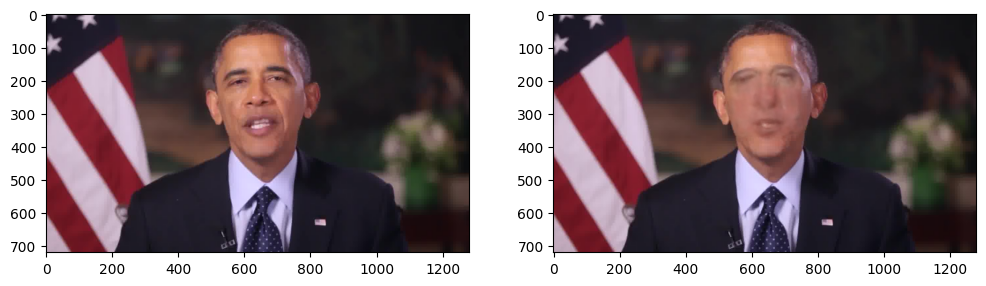

In [40]:
import matplotlib.image as mp_image
import matplotlib.pyplot as plt

img_path = '011.jpg'
orgface = mp_image.imread('obama-jpg/'+img_path)
newface = mp_image.imread('test/'+img_path)
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(orgface)
plt.subplot(122)
plt.imshow(newface)
plt.show()

**동영상 만들기 개요**  
1. mp4 다운로드  
2. ffmpeg을 이용하여 모든 frame 추출  
   `ffmpeg -i ../obama.mp4 file%04d.jpg`  
3. faceswap 실행  
4. 변환된 이미지를 다시 동영상으로 인코딩  
   `ffmpeg -framerate 29.97 -pattern_type glob -i '*.jpg' ../obama-swap.mp4`  

In [ ]:
#@title <font size="5">← ឵឵<i>FFMPEG 설치</font> { vertical-output: true }
from IPython.display import clear_output
import os, urllib.request
HOME = os.path.expanduser("~")
pathDoneCMD = f'{HOME}/doneCMD.sh'
if not os.path.exists(f"{HOME}/.ipython/ttmg.py"):
    hCode = "https://raw.githubusercontent.com/yunooooo/gcct/master/res/ttmg.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ttmg.py")

from ttmg import (
    loadingAn,
    textAn,
)

loadingAn(name="lds")
textAn("Installing Dependencies...", ty='twg')
os.system('pip install git+git://github.com/AWConant/jikanpy.git')
os.system('add-apt-repository -y ppa:jonathonf/ffmpeg-4')
os.system('apt-get update')
os.system('apt install mediainfo')
os.system('apt-get install ffmpeg')
clear_output()
print('Installation finished.')

샘플 동영상 변환 예

In [ ]:
!ffmpeg -framerate 10 -pattern_type glob -i 'obama-jpg/???.jpg' -framerate 10 -pattern_type glob -i 'test/???.jpg' -filter_complex hstack output.mp4 -y


동영상 재생

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)